In [1]:
import sys
sys.path.insert(0, '/cellar/users/dlaub/projects/log_euclidean_signature/les-distance/les')

In [2]:
from les import les_desc_comp, les_dist_comp
import bento
import seaborn as sns
import numpy as np
from tqdm import tqdm
import leidenalg as lei
from scipy.spatial.distance import cdist
import igraph as ig
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import polars as pl

In [3]:
adata = bento.io.read_h5ad("/cellar/users/ckmah/spatial/process_datasets/petukhov2022_1scanpy.h5ad")
bento.tl.flow(adata, mode="point", radius=20, normalization="log", reduce=True)

  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.
AnnData object modified:
    uns:
        + flow, flow_pca, flow_genes


In [4]:
adata.uns['points'].reset_index(drop=True, inplace=True)

In [5]:
min_pts = 92
gt_92_pts = adata.uns['points'].groupby('cell').transform('count')['x'] >= min_pts
points = adata.uns['points'][gt_92_pts].reset_index(drop=True)
points['gene'] = points['gene'].cat.remove_unused_categories()
points['cell'] = points['cell'].cat.remove_unused_categories()
points['nucleus'] = points['nucleus'].cat.remove_unused_categories()
flow = adata.uns['flow'][gt_92_pts]
obs = adata.obs[adata.obs.index.isin(points['cell'].unique())]

In [7]:
ss = StandardScaler()
ss_flow = ss.fit_transform(flow.todense())

### LES on RNAflow

Gist:
1. Get RNAflow (represent each point as gene counts of neighbors) $\to$ (p g)
2. For each cell, get a pairwise distance matrix from the RNAflow representation $\to$ (c p p)
3. For each cell's pdist matrix, compute the LE descriptor (log eigenvalues) $\to$ (c p)
4. Cluster the cells using their LE descriptors (from cell-pairwise LES). (c c) $\to$ (c) clusters

This doesn't recover anything resembling cell types. Why?
- Needed to standardize the counts
- Because distances destroy gene-level information i.e. $d([1, 0], [0, 0]) = d([0, 1], [0, 0])$ but different genes are driving the difference. Gene-level information identifies cell type.

In [11]:
# takes ~2 minutes with sparse matrices (non-standardized)
# takes ~3.5 minutes with dense matrices (standardized)
les_desc = []
for cell_id, g in tqdm(points.groupby('cell')):
    les_desc.append(les_desc_comp(ss_flow[g.index], nev=min_pts))
cell_les = np.stack(les_desc, axis=0)
np.save('/cellar/users/dlaub/projects/log_euclidean_signature/data/cell_les.npy', cell_les)
# cell_les = np.load('/cellar/users/dlaub/projects/log_euclidean_signature/data/cell_les.npy')

100%|██████████| 1112/1112 [03:26<00:00,  5.38it/s]


In [15]:
pdists = cdist(cell_les, cell_les)

In [13]:
row_colors = obs['leiden'].astype(str).map(dict(zip(obs['leiden'].unique(), sns.color_palette('tab10', obs['leiden'].nunique()))))

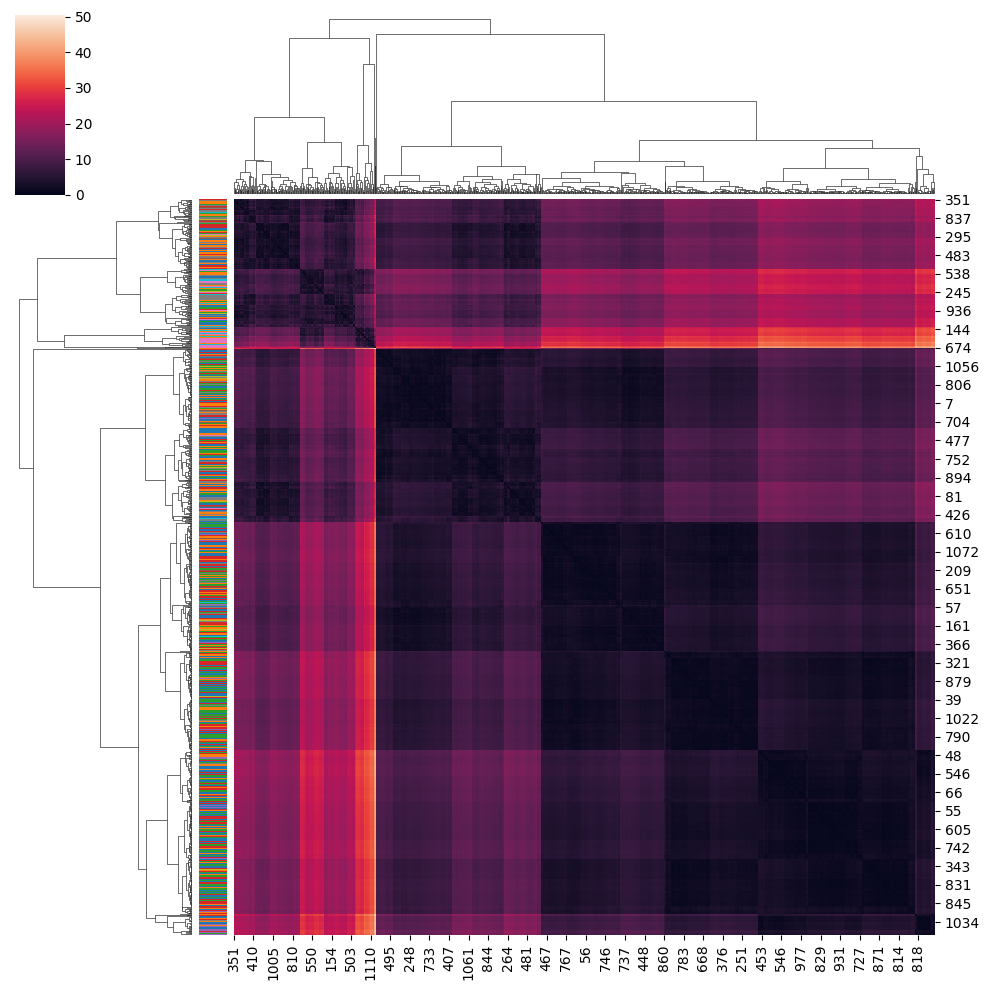

In [16]:
sns.clustermap(pdists, row_colors=row_colors.to_numpy())

In [17]:
clusters = lei.find_partition(ig.Graph.Adjacency(pdists), lei.RBConfigurationVertexPartition)
clusters = np.array(clusters.membership)

In [28]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2]), array([395, 382, 335]))

In [18]:
cmap = dict(zip(np.unique(clusters), sns.color_palette('tab10', len(np.unique(clusters)))))

In [24]:
sorter = np.argsort(obs['leiden'])

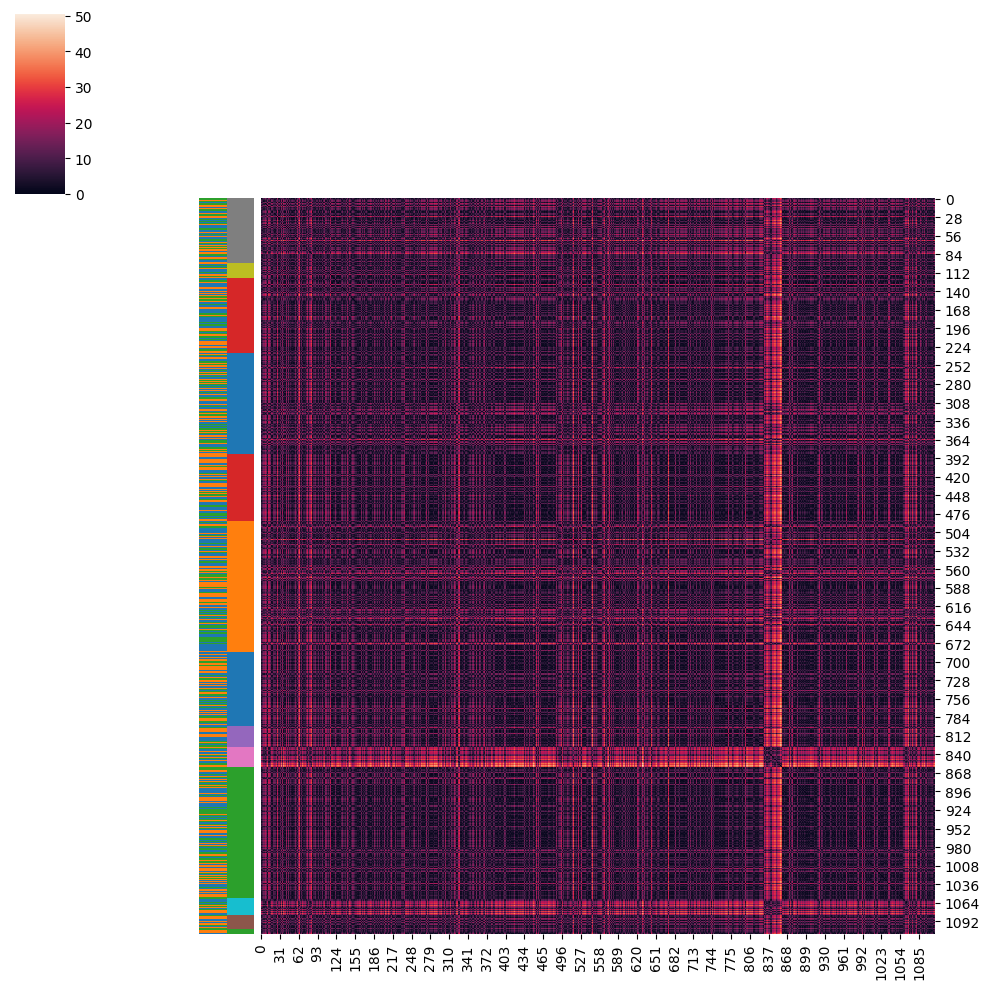

In [26]:
sns.clustermap(pdists[sorter][:, sorter], row_colors=[[cmap[c] for c in clusters[sorter]], row_colors.to_numpy()[sorter]], row_cluster=False, col_cluster=False)

### LES on each gene separately

Gist:
1. For each cell and gene (c g), get kNN graph. $\to$ (g c n n)
2. Compute LE descriptor of each kNN graph. $\to$ (g c n)
3. For each gene, compute the LE signatures between all cells. $\to$ (g c c)
4. Compute multiplex Leiden clusters, letting each gene represent a different edge type. $\to$ (c)

In [7]:
pl_points = pl.from_pandas(points)

In [10]:
pl_points.head()

x,y,gene,cell,nucleus
i64,i64,cat,cat,cat
4139,186,"""Fzd5""","""100""","""-1"""
4227,275,"""Klk1""","""100""","""100"""
4210,216,"""Klk1""","""100""","""100"""
4178,198,"""Klk1""","""100""","""100"""
4185,213,"""Klk1""","""100""","""100"""


In [127]:
pl_points.select(pl.col('gene').unique()).head().to_series().to_list()

['Acsl1', 'Acta2', 'Ada', 'Adgrd1', 'Adgrf5']

In [129]:
test = (
    pl_points
    .groupby(['cell', 'gene'])
    .count()
    .pivot('count', 'cell', 'gene')
    .fill_null(0)
    .melt('cell', variable_name='gene', value_name='count')
    .filter(pl.col('gene').is_in(['Acsl1', 'Acta2', 'Ada', 'Adgrd1', 'Adgrf5']))
)

In [131]:
sns.displot(test, x='count', col='gene')

In [11]:
nn = NearestNeighbors(n_neighbors=7)

In [25]:
(
    pl_points
    .head(500)
    .groupby(['cell', 'gene'])
    .apply(lambda g: nn.fit(g[['x', 'y']].to_numpy()).kneighbors_graph())
)

thread '<unnamed>' panicked at 'UDF failed: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 8', src/dataframe.rs:1073:31
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: UDF failed: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 8